<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment01/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
##Nama  : Sapto Nugroho
##NIU   : 565712

In [47]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

PCD  sample_data
fatal: destination path 'PCD' already exists and is not an empty directory.
PCD  sample_data


###Import

In [48]:
import cv2
import pandas as pd
import numpy as np
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

###Image Acquisition

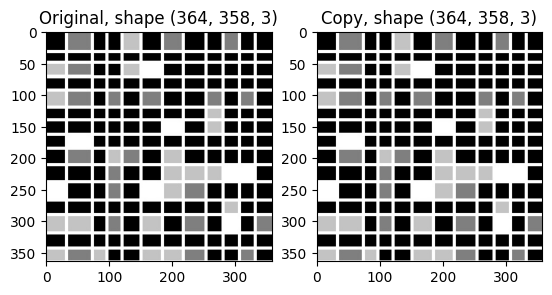

In [49]:
def Acquire(src):
  #Image and Copy
  img = plt.imread(src)
  img_copy = img.copy()

  #Plot Image
  plt.subplot(1,2,1)
  # plt.figure()
  plt.title(f"Original, shape {img.shape}")
  plt.imshow(img)

  #Plot Copy
  plt.subplot(1,2,2)
  # plt.figure()
  plt.title(f"Copy, shape {img_copy.shape}")
  plt.imshow(img_copy)

  return img, img_copy

img_path = '/content/PCD/PCD_Assignment01/grid.jpg'

img,img_copy = Acquire(img_path)
# print(img,img_copy)

###Downsampling

baris = 91, sisa baris = 0
kolom = 89, sisa kolom = 2
(364, 358, 3) ==> (91, 89, 3)


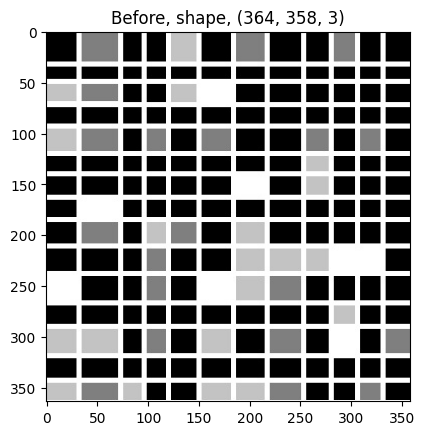

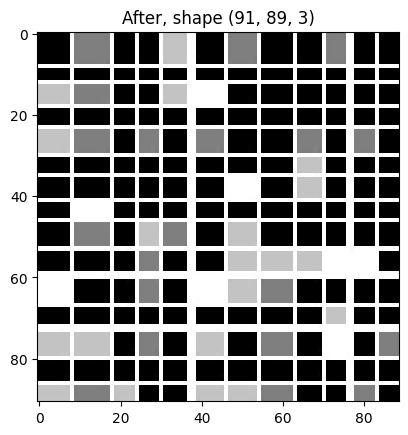

In [45]:
def DownSample(img_copy,order):
  div = 2**order

  #baris
  baris = img_copy.shape[0]//div
  print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

  #kolom
  kolom = img_copy.shape[1]//div
  print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

  #Matriks Image DownSample (img_ds)
  img_ds = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  print(img_copy.shape,"==>",img_ds.shape)
  #print(img_ds)

  #DownSampling
  for j in range(0,img_ds.shape[0]):
    # print("J= ",j,j*div)
    for i in range(0,img_ds.shape[1]):
      # print(i, i*div)
      img_ds[j][i] = img_copy[j*div][i*div]

  # plt.subplot(1,2,1)
  plt.figure()
  plt.imshow(img_copy)
  plt.title(f"Before, shape, {img_copy.shape}")
  # plt.subplot(1,2,2)
  plt.figure()
  plt.title(f"After, shape {img_ds.shape}")
  plt.imshow(img_ds)

  return img_ds

img_ds = DownSample(img_copy,2)
# print(img_ds)


###Decimation

In [89]:
A = np.random.randint(0, 10, size=(4, 4))
print(A)

B = np.zeros(shape=(2,2))
print(B)

# C = np.zeros(shape=(4))
# print(C)

# def Decimation(A,B,order):
#   div = 2**order
#   for i in range(0,div):
#     for j in range(0,div):
#       C += A[i][j]
#       print

div = 2**1
# print(div)
for i in range(0,2):
  for j in range(i,div):
    for k in range(i,div):
      print("i:",i,"j:",j+i," k:",k+i)
      print("A:",A[i+j][i+k])
      B[i] += A[i+j][i+k]
      print("B:\n",B)


[[3 0 3 8]
 [5 3 4 9]
 [4 1 0 6]
 [1 8 1 7]]
[[0. 0.]
 [0. 0.]]
i: 0 j: 0  k: 0
A: 3
B:
 [[3. 3.]
 [0. 0.]]
i: 0 j: 0  k: 1
A: 0
B:
 [[3. 3.]
 [0. 0.]]
i: 0 j: 1  k: 0
A: 5
B:
 [[8. 8.]
 [0. 0.]]
i: 0 j: 1  k: 1
A: 3
B:
 [[11. 11.]
 [ 0.  0.]]
i: 1 j: 2  k: 2
A: 0
B:
 [[11. 11.]
 [ 0.  0.]]


In [ ]:
A = np.random.randint(0, 10, size=(4, 4))
print(A)

B = np.zeros(shape=(2,2))
print(B)

for i in range(0,B.shape[0]):
  for j in range(0,B.shape[1]):
    B[i][j] = round((A[i*2][j*2]+A[i*2][(j*2)+1]+A[(i*2)+1][0]+A[(i*2)+1][(j*2)+1])/4)
    print((A[i*2][j*2]+A[i*2][(j*2)+1]+A[(i*2)+1][0]+A[(i*2)+1][(j*2)+1])/4)
    print(B[i][j])
    print(B)

print(B)

In [ ]:
def Decimate(img_copy,order):
  div = 2**order

  #baris
  baris = img_copy.shape[0]//div
  print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

  #kolom
  kolom = img_copy.shape[1]//div
  print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

  #Matriks Image Decimation (img_dc)
  img_dc = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  print(img_copy.shape,"==>",img_dc.shape)
  #print(img_dc)

  #Decimation
  for j in range(0,img_dc.shape[0]):
    # print("J= ",j,j*div)
    for i in range(0,img_dc.shape[1]):
      # print(i, i*div)
      img_dc[j][i] = img_copy[j*div][i*div]

  for i in range(0,img_dc.shape[0]):
    for j in range(0,img_dc.shape[1]):
      img_dc.shape[i][j] = round((img_copy[i*div][j*div]+img_copy[i*div][(j*div)+1]+img_copy[(i*div)+1][0]+img_copy[(i*div)+1][(j*div)+1])/4)
      print((img_copy[i*div][j*div]+img_copy[i*div][(j*div)+1]+img_copy[(i*div)+1][0]+img_copy[(i*div)+1][(j*div)+1])/4)
      print(img_dc[i][j])
      # print(img_dc)

  print(B)

  # plt.subplot(1,2,1)
  plt.figure()
  plt.imshow(img_copy)
  plt.title(f"Before, shape, {img_copy.shape}")
  # plt.subplot(1,2,2)
  plt.figure()
  plt.title(f"After, shape {img_dc.shape}")
  plt.imshow(img_dc)

  return img_ds


In [ ]:
# print(img02_copy[-1][-1])
print(MDS)
print("===============================")
M = np.array([1,2,3])
print(M.shape)
print(M)
M = M.reshape(1,3)
print(M.shape)
print(M)
print("===============================")
print(MDS[0].shape)
# MDS = np.append(M_DS,M)
MDS[0] = np.concatenate((MDS[0],M),axis=1)
# C = np.concatenate((M,MDS[0][0]),axis=0)
print(MDS[0][0].shape)
print(MDS)


In [ ]:
# pd.Series(img01.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

flat = img02.flatten()
# print(flat.shape)
# print(flat)

A = []

for i in range(len(flat)):
  if i%3==0:
    A.append(int(flat[i]))

A = np.array(A)
print(A[0].dtype)

# pd.Series(img02.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

int64


##junk

In [ ]:
# img2 = mpimg.imread(img02_path)
# plt.imshow(img2)
# plt.axis('off')
# plt.show()

In [ ]:
A = np.zeros( (2, 3, 5) )
print("A = {}\n".format(A))
## 1rst term => depth
## 2 other terms => (i,j)

## basic 2D array
B = np.ones( (1,3, 5) )
print("B = {}\n".format(B))

## 2D array reshaped into 3D one prior to be concatenated
# Bprime = B.reshape(1,3,5)
# print("Bprime = {}\n".format(Bprime))

## C is created and suppoed to be A expanded by B
# C = np.concatenate( (A, Bprime) )
C = np.concatenate( (A, B), axis = 0)
print("C = {}\n".format(C))

In [ ]:
# length = len(flat)/3
# length = int(length)

# empty02 = np.zeros(shape=(length),dtype=np.uint8)
# print(empty02)